In [72]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb  3 17:07:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    36W / 250W |  15981MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [73]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.6 s (started: 2022-02-03 17:07:08 +00:00)


In [74]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 3 ms (started: 2022-02-03 17:07:13 +00:00)


In [75]:
!pip install --quiet optuna

time: 3.45 s (started: 2022-02-03 17:07:13 +00:00)


In [76]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils.layer_utils import count_params

import optuna # hyeperparam optimization 

time: 19.6 ms (started: 2022-02-03 17:07:16 +00:00)


# Variables

## Paths

In [77]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220203_17H07/
time: 13.5 ms (started: 2022-02-03 17:07:16 +00:00)


## Other

In [78]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 5000 # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# epoch
epochs = 10
# learing rate 
# learning_rate = 0.001 # a learning rate of 0.001 is often used / working
# batch size 
batch_size = 32 #32
# base model trainable 
base_model_trainable = True

# number of trials optuna
n_trials = 25 

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 20.4 ms (started: 2022-02-03 17:07:16 +00:00)


# Load & filter data

## Unzip images

In [79]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 4.62 ms (started: 2022-02-03 17:07:16 +00:00)


In [80]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 8.58 ms (started: 2022-02-03 17:07:16 +00:00)


## File_path df

In [81]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.



,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 1.99 s (started: 2022-02-03 17:07:16 +00:00)


In [82]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 5.4 ms (started: 2022-02-03 17:07:18 +00:00)


In [83]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 314 ms (started: 2022-02-03 17:07:18 +00:00)


In [84]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 191 ms (started: 2022-02-03 17:07:19 +00:00)


In [85]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 59.4 ms (started: 2022-02-03 17:07:19 +00:00)


In [86]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 64.8 ms (started: 2022-02-03 17:07:19 +00:00)


In [87]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 71.4 ms (started: 2022-02-03 17:07:19 +00:00)


In [88]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 25.8 ms (started: 2022-02-03 17:07:19 +00:00)


In [89]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 40.2 ms (started: 2022-02-03 17:07:19 +00:00)


In [90]:
# ######### DEBUG LAST 3 FAMILLES TUOMR POUR INCLURE NO TUMOR ############
# # keep only top families 
# top_fam = df_paths['gbif_info.family'].value_counts().index.values[-3:]
# df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
# #############################################

time: 2.06 ms (started: 2022-02-03 17:07:19 +00:00)


In [91]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 83.8 ms (started: 2022-02-03 17:07:19 +00:00)


In [92]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 6.83 ms (started: 2022-02-03 17:07:19 +00:00)


In [93]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
44369,/content/RAW DATA/IMAGES/2010/Russula vinacea/...,Russulaceae,0
172598,/content/RAW DATA/IMAGES/2015/Lactarius delici...,Russulaceae,0
184582,/content/RAW DATA/IMAGES/2015/Tylopilus felleu...,Boletaceae,1
211179,/content/RAW DATA/IMAGES/2016/Russula parazure...,Russulaceae,0
63243,/content/RAW DATA/IMAGES/2011/Psilocybe cyanes...,Strophariaceae,2


time: 34.2 ms (started: 2022-02-03 17:07:19 +00:00)


In [94]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 3.07 ms (started: 2022-02-03 17:07:19 +00:00)


In [95]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 5000


,label,gbif_info.family,size
0,0,Russulaceae,855
1,1,Boletaceae,847
2,2,Strophariaceae,628
3,3,Tricholomataceae,694
4,4,Amanitaceae,666
5,5,Agaricaceae,734
6,6,Cortinariaceae,576


time: 24.8 ms (started: 2022-02-03 17:07:19 +00:00)


In [96]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Russulaceae',
 '1': 'Boletaceae',
 '2': 'Strophariaceae',
 '3': 'Tricholomataceae',
 '4': 'Amanitaceae',
 '5': 'Agaricaceae',
 '6': 'Cortinariaceae'}

time: 7.16 ms (started: 2022-02-03 17:07:19 +00:00)


## Train/test split

In [97]:
#train/test 
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
print(df_train.shape,df_test.shape)

(4000, 3) (1000, 3)
time: 22.1 ms (started: 2022-02-03 17:07:19 +00:00)


In [98]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 5.72 ms (started: 2022-02-03 17:07:19 +00:00)


### Plot few images

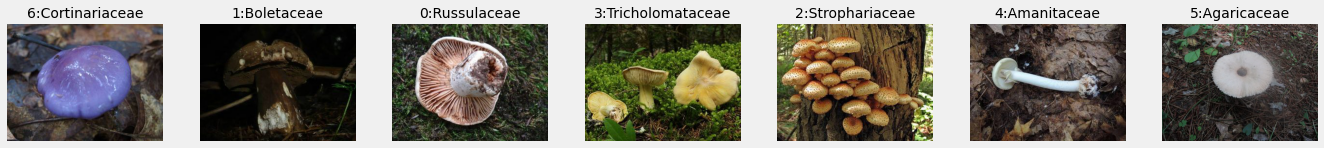

time: 517 ms (started: 2022-02-03 17:07:19 +00:00)


In [99]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

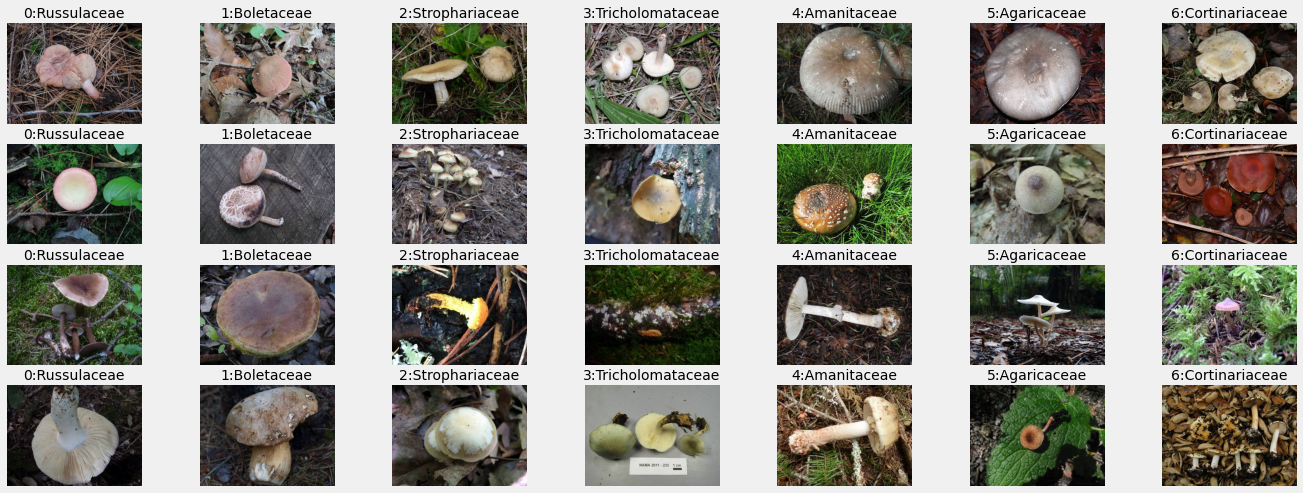

time: 1.82 s (started: 2022-02-03 17:07:20 +00:00)


In [100]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Fonctions & Callbacks

In [101]:
# model 
def define_model(model_name,base_model):
  base_model = base_model
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
  dense1 = tf.keras.layers.Dense(units = 1024, activation = 'relu')
  dropout1 = tf.keras.layers.Dropout(0.3)
  dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')
  dropout2 = tf.keras.layers.Dropout(0.5)
  prediction_layer =  Dense(units = classes_count, activation = 'softmax')


  for layer in base_model.layers:
      layer.trainable = base_model_trainable

  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense1, 
    dropout1,
    dense2,
    dropout2,
    prediction_layer
  ],
  name = model_name)
  return model



time: 15.1 ms (started: 2022-02-03 17:07:22 +00:00)


In [102]:
def plot_history(history,pathinfos):
  # train_acc_model = history.history['accuracy']
  # val_acc_model = history.history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history.history['loss'])), history.history['loss'], '-o', label = "training")
  plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 22.7 ms (started: 2022-02-03 17:07:22 +00:00)


In [103]:
early_stopping = EarlyStopping(
                                patience=4, # Attendre 5 epochs avant application
                                min_delta = 0.02, # si au bout de 5 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=3, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.01,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 8.05 ms (started: 2022-02-03 17:07:22 +00:00)


# Optuna 

Ici on va chercher la meilleure architecture post base model en cherchant entre 2 et 5 couples de couches Dense/Dropout avec nombre d'units et dropout rate différents

* https://github.com/optuna/optuna-examples/blob/main/keras/keras_simple.py
* https://www.kaggle.com/takeshikobayashi/mnist-cnn-keras-with-optuna-visualization
* https://www.kaggle.com/kageyama/how-to-use-optuna-to-keras
* https://stackoverflow.com/questions/59737875/keras-change-learning-rate
* https://tech.preferred.jp/en/blog/how-we-implement-hyperband-in-optuna/

## Dict of models 

In [104]:
model_dict = {
    'EFB1' : tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'EFB0' : tf.keras.applications.EfficientNetB0(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNetV3Large': tf.keras.applications.MobileNetV3Large(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
}

time: 6.45 s (started: 2022-02-03 17:07:22 +00:00)


## Choose model

In [105]:
# define model 
model_name  = 'EFB1'
base_model = model_dict[model_name]
# csv start path infos 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'

time: 3.24 ms (started: 2022-02-03 17:07:28 +00:00)


## Hyperparam optimization

[I 2022-02-03 17:07:28,936] A new study created in memory with name: no-name-66766700-f0ed-421f-8473-da88f19b7b25


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 0:{'batch_size': 32, 'num_layer': 5, 'num_units_0': 512, 'dropout_rate_0': 0.45, 'num_units_1': 128, 'dropout_rate_1': 0.0, 'num_units_2'
: 32, 'dropout_rate_2': 0.5, 'num_units_3': 128, 'dropout_rate_3': 0.05, 'num_units_4': 2048, 'dropout_rate_4': 0.0, 'lr': 3.61558873766282e-05}
layer.trainable = True : trainable_count = 7521607 / non_trainable_count =  62055
Epoch 1/10
100/100 [==============================] - 73s 555ms/step - loss: 1.9468 - accuracy: 0.1403 - val_loss: 1.9451 - val_accuracy: 0.1475 - lr: 3.6156e-05
Epoch 2/10
100/100 [==============================] - 53s 533ms/step - loss: 1.9400 - accuracy: 0.1637 - val_loss: 1.9329 - val_accuracy: 0.2013 - lr: 3.6156e-05
Epoch 3/10
100/100 [==============================] - 53s 531ms

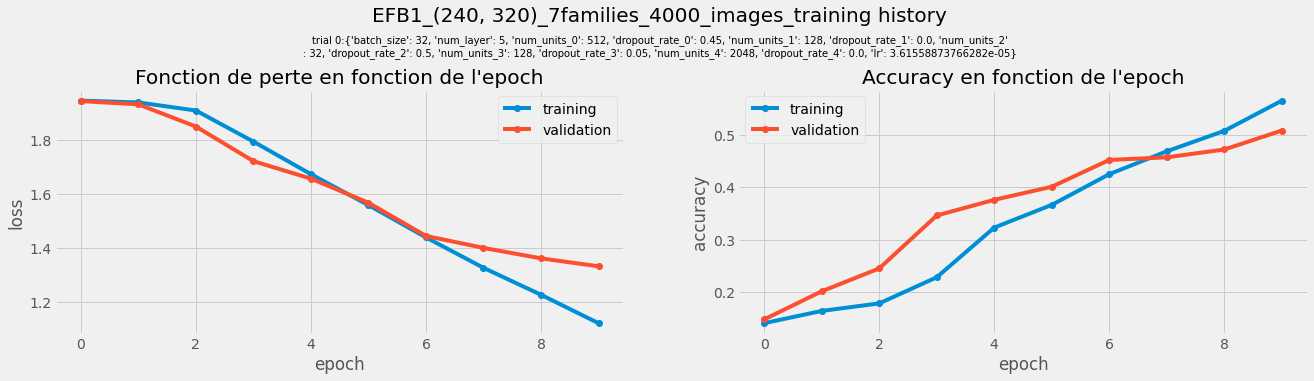

[I 2022-02-03 17:20:32,818] Trial 0 finished with value: 0.5087500214576721 and parameters: {'batch_size': 32, 'num_layer': 5, 'num_units_0': 512, 'dropout_rate_0': 0.45, 'num_units_1': 128, 'dropout_rate_1': 0.0, 'num_units_2': 32, 'dropout_rate_2': 0.5, 'num_units_3': 128, 'dropout_rate_3': 0.05, 'num_units_4': 2048, 'dropout_rate_4': 0.0, 'lr': 3.61558873766282e-05}. Best is trial 0 with value: 0.5087500214576721.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 1:{'batch_size': 16, 'num_layer': 2, 'num_units_0': 64, 'dropout_rate_0':
 0.05, 'num_units_1': 128, 'dropout_rate_1': 0.0, 'lr': 0.00020745761475975163}
layer.trainable = True : trainable_count = 6604391 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 78s 316ms/step - loss: 1.6033 - accuracy: 0.4066 - val_loss: 1.2235 - val_accuracy: 0.5500 - lr: 2.0746e-04
Epoch 2/10
200/200 [==============================] - 61s 306ms/step - loss: 1.0018 - accuracy: 0.6481 - val_loss: 1.0945 - val_accuracy: 0.5962 - lr: 2.0746e-04
Epoch 3/10
200/200 [==============================] - 61s 306ms/step - loss: 0.6315 - accuracy: 0.7887 - val_loss: 1.2058 - val_accuracy: 0.6012 - lr: 2.0746e-04
Epoch 4/10
200/200 [==========

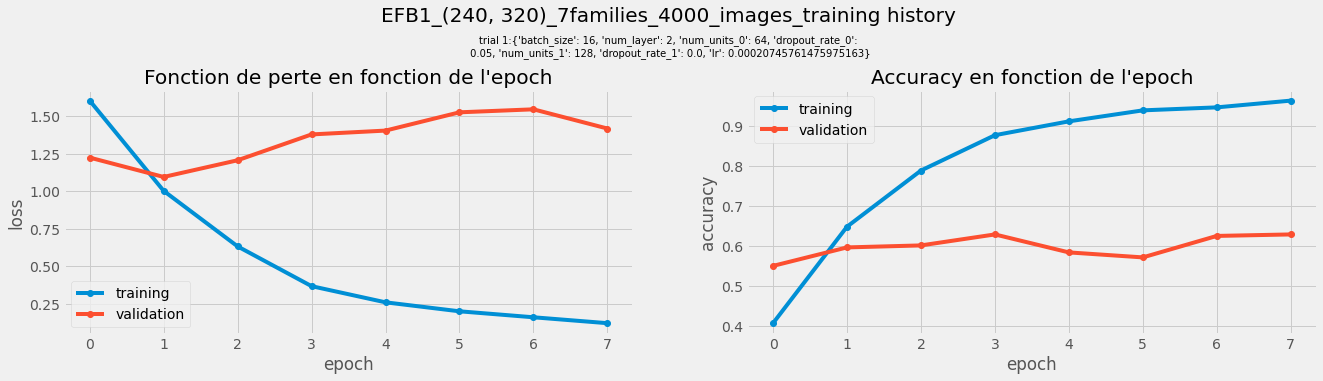

[I 2022-02-03 17:30:45,345] Trial 1 finished with value: 0.6287500262260437 and parameters: {'batch_size': 16, 'num_layer': 2, 'num_units_0': 64, 'dropout_rate_0': 0.05, 'num_units_1': 128, 'dropout_rate_1': 0.0, 'lr': 0.00020745761475975163}. Best is trial 1 with value: 0.6287500262260437.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 2:{'batch_size': 16, 'num_layer': 2, 'num_units_0': 64, 'dropout_rate_0'
: 0.4, 'num_units_1': 32, 'dropout_rate_1': 0.5, 'lr': 2.2783855553657513e-05}
layer.trainable = True : trainable_count = 6597479 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 81s 318ms/step - loss: 2.0046 - accuracy: 0.1506 - val_loss: 1.9149 - val_accuracy: 0.1850 - lr: 2.2784e-05
Epoch 2/10
200/200 [==============================] - 61s 306ms/step - loss: 1.9489 - accuracy: 0.1694 - val_loss: 1.8937 - val_accuracy: 0.2275 - lr: 2.2784e-05
Epoch 3/10
200/200 [==============================] - 61s 307ms/step - loss: 1.9099 - accuracy: 0.2006 - val_loss: 1.8709 - val_accuracy: 0.2738 - lr: 2.2784e-05
Epoch 4/10
200/200 [============

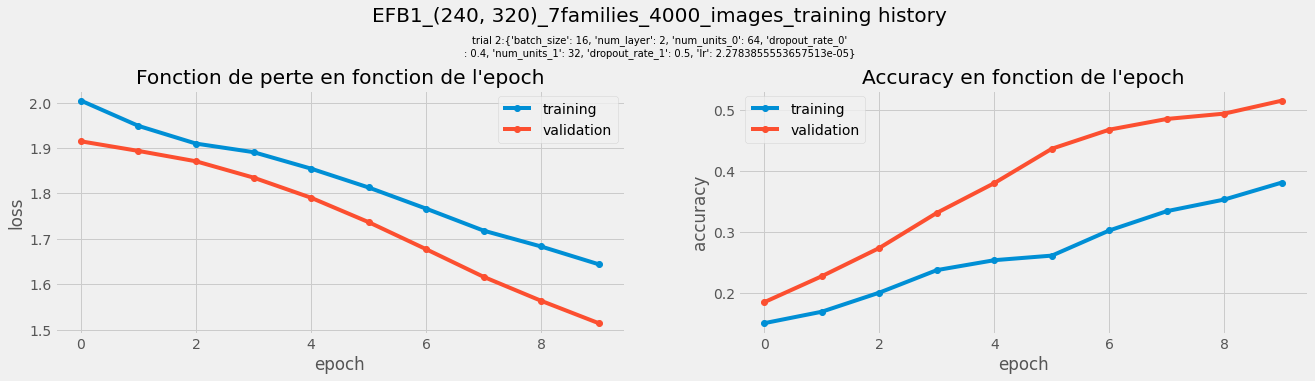

[I 2022-02-03 17:44:07,304] Trial 2 finished with value: 0.5149999856948853 and parameters: {'batch_size': 16, 'num_layer': 2, 'num_units_0': 64, 'dropout_rate_0': 0.4, 'num_units_1': 32, 'dropout_rate_1': 0.5, 'lr': 2.2783855553657513e-05}. Best is trial 1 with value: 0.6287500262260437.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 3:{'batch_size': 16, 'num_layer': 4, 'num_units_0': 128, 'dropout_rate_0': 0.35000000000000003, 'num_units_1': 1024, 'dropout_rate_1': 0.1500
0000000000002, 'num_units_2': 64, 'dropout_rate_2': 0.30000000000000004, 'num_units_3': 2048, 'dropout_rate_3': 0.45, 'lr': 0.00010216277584051456}
layer.trainable = True : trainable_count = 7022311 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 79s 319ms/step - loss: 1.9251 - accuracy: 0.1897 - val_loss: 1.7704 - val_accuracy: 0.3700 - lr: 1.0216e-04
Epoch 2/10
200/200 [==============================] - 61s 306ms/step - loss: 1.6058 - accuracy: 0.3944 - val_loss: 1.3025 - val_accuracy: 0.5337 - lr: 1.0216e-04
Epoch 3/10
200/200 [==============================] - 61

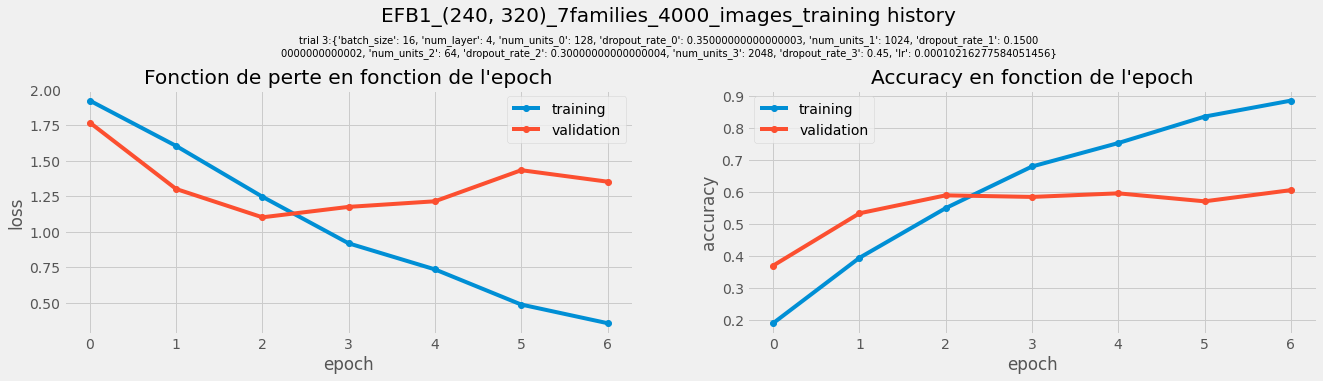

[I 2022-02-03 17:53:42,193] Trial 3 finished with value: 0.606249988079071 and parameters: {'batch_size': 16, 'num_layer': 4, 'num_units_0': 128, 'dropout_rate_0': 0.35000000000000003, 'num_units_1': 1024, 'dropout_rate_1': 0.15000000000000002, 'num_units_2': 64, 'dropout_rate_2': 0.30000000000000004, 'num_units_3': 2048, 'dropout_rate_3': 0.45, 'lr': 0.00010216277584051456}. Best is trial 1 with value: 0.6287500262260437.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 4:{'batch_size': 32, 'num_layer': 4, 'num_units_0': 64, 'dropout_rate_0': 0.30000000000000004, 'num_units_1': 1024, 'dropout_rate_1'
: 0.05, 'num_units_2': 32, 'dropout_rate_2': 0.25, 'num_units_3': 2048, 'dropout_rate_3': 0.15000000000000002, 'lr': 0.0007578024870019003}
layer.trainable = True : trainable_count = 6776455 / non_trainable_count =  62055
Epoch 1/10
100/100 [==============================] - 71s 558ms/step - loss: 1.8263 - accuracy: 0.2547 - val_loss: 1.7393 - val_accuracy: 0.4075 - lr: 7.5780e-04
Epoch 2/10
100/100 [==============================] - 53s 534ms/step - loss: 1.5356 - accuracy: 0.4512 - val_loss: 1.6260 - val_accuracy: 0.3787 - lr: 7.5780e-04
Epoch 3/10
100/100 [==============================] - 53s 532ms/step - lo

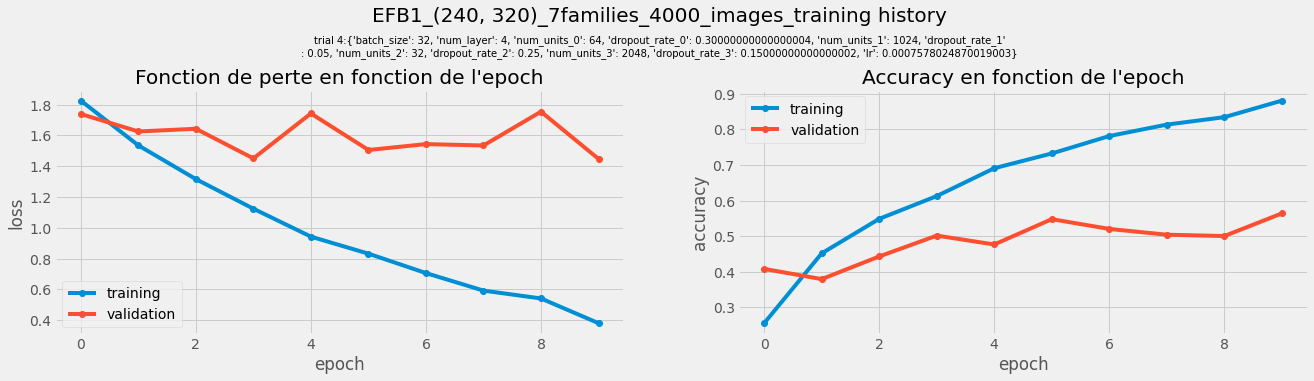

[I 2022-02-03 18:05:49,588] Trial 4 finished with value: 0.5637500286102295 and parameters: {'batch_size': 32, 'num_layer': 4, 'num_units_0': 64, 'dropout_rate_0': 0.30000000000000004, 'num_units_1': 1024, 'dropout_rate_1': 0.05, 'num_units_2': 32, 'dropout_rate_2': 0.25, 'num_units_3': 2048, 'dropout_rate_3': 0.15000000000000002, 'lr': 0.0007578024870019003}. Best is trial 1 with value: 0.6287500262260437.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 5:{'batch_size': 16, 'num_layer': 2, 'num_units_0': 512, 'dropout_rate_0
': 0.45, 'num_units_1': 64, 'dropout_rate_1': 0.4, 'lr': 5.981409392063496e-05}
layer.trainable = True : trainable_count = 7202343 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 79s 320ms/step - loss: 1.9540 - accuracy: 0.1934 - val_loss: 1.8025 - val_accuracy: 0.3800 - lr: 5.9814e-05
Epoch 2/10
200/200 [==============================] - 62s 308ms/step - loss: 1.7700 - accuracy: 0.3128 - val_loss: 1.5457 - val_accuracy: 0.4737 - lr: 5.9814e-05
Epoch 3/10
200/200 [==============================] - 61s 307ms/step - loss: 1.5247 - accuracy: 0.4297 - val_loss: 1.3237 - val_accuracy: 0.5163 - lr: 5.9814e-05
Epoch 4/10
200/200 [===========

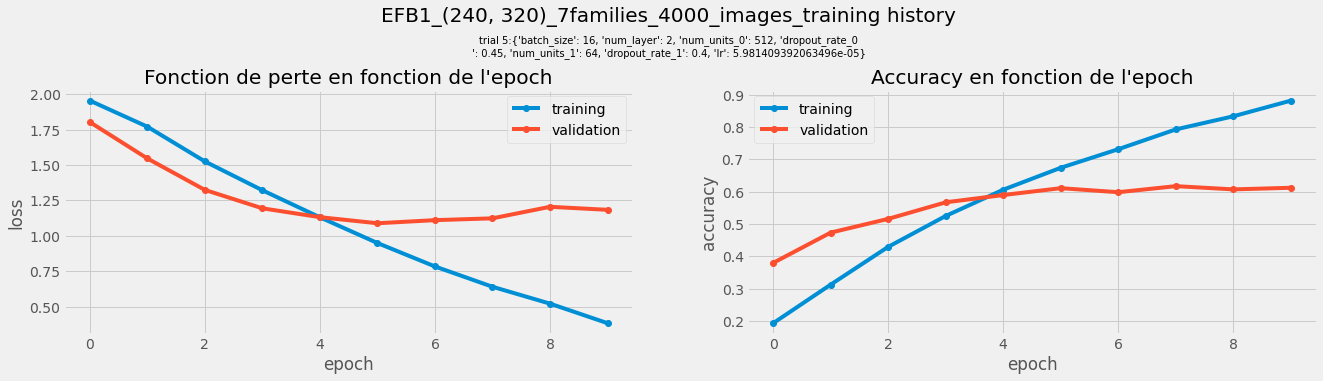

[I 2022-02-03 18:18:49,344] Trial 5 finished with value: 0.612500011920929 and parameters: {'batch_size': 16, 'num_layer': 2, 'num_units_0': 512, 'dropout_rate_0': 0.45, 'num_units_1': 64, 'dropout_rate_1': 0.4, 'lr': 5.981409392063496e-05}. Best is trial 1 with value: 0.6287500262260437.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 6:{'batch_size': 32, 'num_layer': 5, 'num_units_0': 128, 'dropout_rate_0': 0.30000000000000004, 'num_units_1': 32, 'dropout_rate_1': 0.25, 'num_units_2': 2048, '
dropout_rate_2': 0.0, 'num_units_3': 256, 'dropout_rate_3': 0.35000000000000003, 'num_units_4': 32, 'dropout_rate_4': 0.35000000000000003, 'lr': 0.0004748790953569679}
layer.trainable = True : trainable_count = 7281863 / non_trainable_count =  62055
Epoch 1/10
100/100 [==============================] - 70s 557ms/step - loss: 1.9237 - accuracy: 0.1628 - val_loss: 1.8553 - val_accuracy: 0.1975 - lr: 4.7488e-04
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 1.7755 - accuracy: 0.2900

[I 2022-02-03 18:21:23,489] Trial 6 pruned. Trial was pruned at epoch 1.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 7:{'batch_size': 16, 'num_layer': 3, 'num_units_0': 32, 'dropout_rate_0': 0.0, 'num_units_1': 64, 'dr
opout_rate_1': 0.25, 'num_units_2': 64, 'dropout_rate_2': 0.30000000000000004, 'lr': 1.9976373232400406e-05}
layer.trainable = True : trainable_count = 6560903 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 81s 333ms/step - loss: 1.9579 - accuracy: 0.1441 - val_loss: 1.9420 - val_accuracy: 0.1562 - lr: 1.9976e-05
Epoch 2/10
200/200 [==============================] - 62s 308ms/step - loss: 1.9370 - accuracy: 0.1775 - val_loss: 1.9277 - val_accuracy: 0.1988 - lr: 1.9976e-05
Epoch 3/10
200/200 [==============================] - 62s 308ms/step - loss: 1.9143 - accuracy: 0.2106 - val_loss: 1.9034 - val_accurac

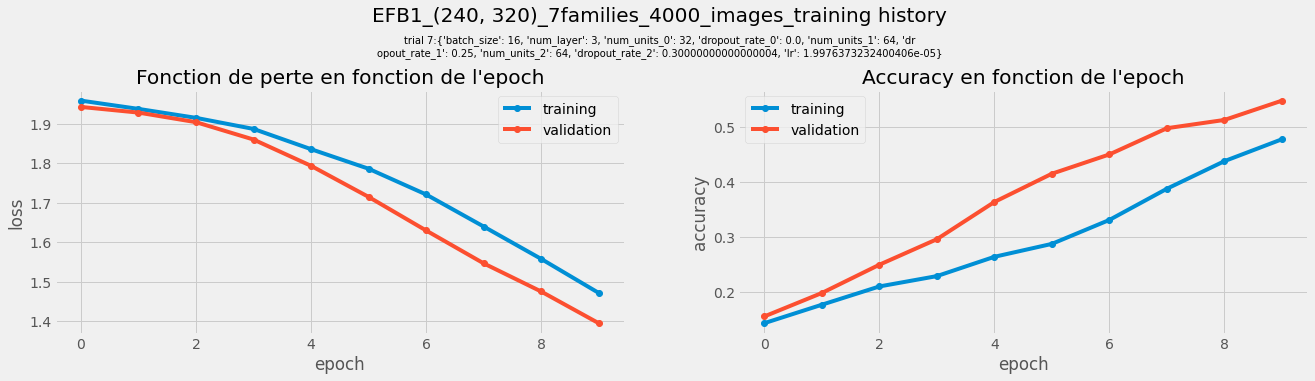

[I 2022-02-03 18:35:09,005] Trial 7 finished with value: 0.5475000143051147 and parameters: {'batch_size': 16, 'num_layer': 3, 'num_units_0': 32, 'dropout_rate_0': 0.0, 'num_units_1': 64, 'dropout_rate_1': 0.25, 'num_units_2': 64, 'dropout_rate_2': 0.30000000000000004, 'lr': 1.9976373232400406e-05}. Best is trial 1 with value: 0.6287500262260437.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 8:{'batch_size': 8, 'num_layer': 3, 'num_units_0': 256, 'dropout_rate_0': 0.15000000000000002, 'num_u
nits_1': 128, 'dropout_rate_1': 0.1, 'num_units_2': 32, 'dropout_rate_2': 0.5, 'lr': 4.865018353845416e-05}
layer.trainable = True : trainable_count = 6878375 / non_trainable_count =  62055
Epoch 1/10
400/400 [==============================] - 98s 207ms/step - loss: 1.9401 - accuracy: 0.1691 - val_loss: 1.8695 - val_accuracy: 0.2812 - lr: 4.8650e-05
Epoch 2/10
400/400 [==============================] - 81s 202ms/step - loss: 1.8365 - accuracy: 0.2478 - val_loss: 1.7168 - val_accuracy: 0.4062 - lr: 4.8650e-05
Epoch 3/10
400/400 [==============================] - 80s 201ms/step - loss: 1.6859 - accuracy: 0.3503 - val_loss: 1.4976 - val_accuracy

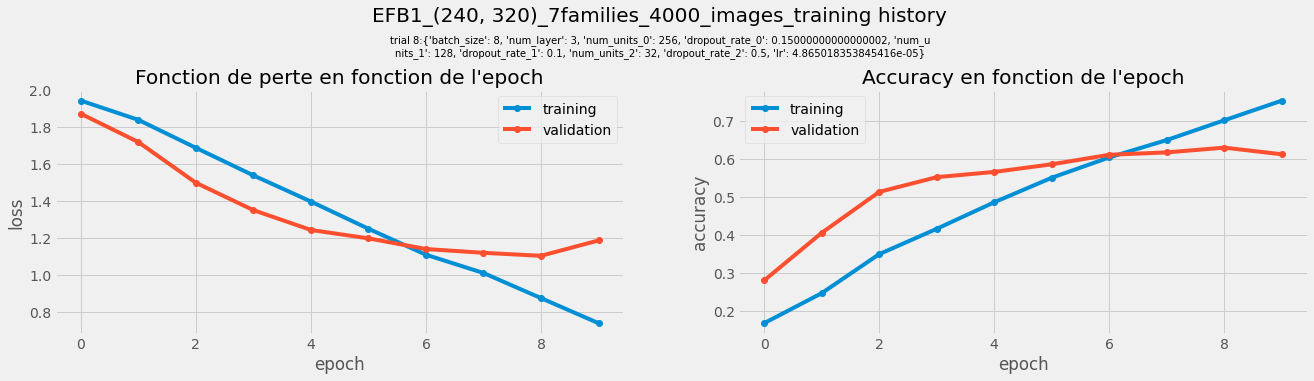

[I 2022-02-03 18:50:06,650] Trial 8 finished with value: 0.612500011920929 and parameters: {'batch_size': 8, 'num_layer': 3, 'num_units_0': 256, 'dropout_rate_0': 0.15000000000000002, 'num_units_1': 128, 'dropout_rate_1': 0.1, 'num_units_2': 32, 'dropout_rate_2': 0.5, 'lr': 4.865018353845416e-05}. Best is trial 1 with value: 0.6287500262260437.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 9:{'batch_size': 8, 'num_layer': 2, 'num_units_0': 256, 'dropout_rate_0'
: 0.0, 'num_units_1': 128, 'dropout_rate_1': 0.1, 'lr': 0.0002461082049088004}
layer.trainable = True : trainable_count = 6874919 / non_trainable_count =  62055
Epoch 1/10
400/400 [==============================] - 97s 206ms/step - loss: 1.5909 - accuracy: 0.4034 - val_loss: 1.2987 - val_accuracy: 0.5362 - lr: 2.4611e-04
Epoch 2/10
400/400 [==============================] - 80s 201ms/step - loss: 1.1376 - accuracy: 0.6087 - val_loss: 1.2450 - val_accuracy: 0.5663 - lr: 2.4611e-04
Epoch 3/10
400/400 [==============================] - 80s 201ms/step - loss: 0.8083 - accuracy: 0.7219 - val_loss: 1.2715 - val_accuracy: 0.5612 - lr: 2.4611e-04
Epoch 4/10
400/400 [============

[I 2022-02-03 18:56:51,267] Trial 9 pruned. Trial was pruned at epoch 3.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 10:{'batch_size': 8, 'num_layer': 4, 'num_units_0': 512, 'dropout_rate_0': 0.30000000000000004, 'num_units_1': 128, 'dropout_rate_1
': 0.45, 'num_units_2': 256, 'dropout_rate_2': 0.5, 'num_units_3': 64, 'dropout_rate_3': 0.30000000000000004, 'lr': 0.0002720439805027173}
layer.trainable = True : trainable_count = 7284647 / non_trainable_count =  62055
Epoch 1/10
400/400 [==============================] - 101s 208ms/step - loss: 1.9435 - accuracy: 0.1884 - val_loss: 1.7498 - val_accuracy: 0.3587 - lr: 2.7204e-04
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 1.7841 - accuracy: 0.3066

[I 2022-02-03 19:00:54,860] Trial 10 pruned. Trial was pruned at epoch 1.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 11:{'batch_size': 8, 'num_layer': 5, 'num_units_0': 64, 'dropout_rate_0': 0.5, 'num_units_1': 2048, 'dropout_rate_1': 0.45, 'num_units_2': 32, 'dr
opout_rate_2': 0.1, 'num_units_3': 1024, 'dropout_rate_3': 0.5, 'num_units_4': 2048, 'dropout_rate_4': 0.35000000000000003, 'lr': 0.0008520244588141367}
layer.trainable = True : trainable_count = 8941191 / non_trainable_count =  62055
Epoch 1/10
400/400 [==============================] - 98s 207ms/step - loss: 1.9584 - accuracy: 0.1381 - val_loss: 1.9479 - val_accuracy: 0.1150 - lr: 8.5202e-04
Epoch 2/10
400/400 [==============================] - 81s 203ms/step - loss: 1.9487 - accuracy: 0.1344 - val_loss: 1.9461 - val_accuracy: 0.1338 - lr: 8.5202e-04
Epoch 3/10
400/400 [==========================

[I 2022-02-03 19:07:42,106] Trial 11 pruned. Trial was pruned at epoch 3.



Epoch 00004: ReduceLROnPlateau reducing learning rate to 8.520244737155736e-06.
************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 12:{'batch_size': 16, 'num_layer': 5, 'num_units_0': 256, 'dropout_rate_0': 0.45, 'num_units_1': 1024, 'dropout_rate_1': 0.15000000000000002, 'num_units_2':
 2048, 'dropout_rate_2': 0.0, 'num_units_3': 2048, 'dropout_rate_3': 0.30000000000000004, 'num_units_4': 512, 'dropout_rate_4': 0.1, 'lr': 1.0580135010825692e-05}
layer.trainable = True : trainable_count = 14452519 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 79s 323ms/step - loss: 1.9453 - accuracy: 0.1459 - val_loss: 1.9387 - val_accuracy: 0.2225 - lr: 1.0580e-05
Epoch 2/10
200/200 [==============================] - 63s 313ms/step - loss: 1.9349 - accuracy: 0.1863 - v

[I 2022-02-03 19:13:31,688] Trial 12 pruned. Trial was pruned at epoch 3.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 13:{'batch_size': 32, 'num_layer': 3, 'num_units_0': 512, 'dropout_rate_0': 0.1, 'num_units_1': 32, 'dropout_r
ate_1': 0.30000000000000004, 'num_units_2': 2048, 'dropout_rate_2': 0.30000000000000004, 'lr': 7.63864776890771e-05}
layer.trainable = True : trainable_count = 7267399 / non_trainable_count =  62055
Epoch 1/10
100/100 [==============================] - 74s 560ms/step - loss: 1.9303 - accuracy: 0.1825 - val_loss: 1.8515 - val_accuracy: 0.2900 - lr: 7.6386e-05
Epoch 2/10
100/100 [==============================] - 54s 538ms/step - loss: 1.6847 - accuracy: 0.3963 - val_loss: 1.3737 - val_accuracy: 0.4800 - lr: 7.6386e-05
Epoch 3/10
100/100 [==============================] - 53s 534ms/step - loss: 1.2835 - accuracy: 0.5369 - val_loss: 1.2

[I 2022-02-03 19:26:29,347] Trial 13 pruned. Trial was pruned at epoch 9.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 14:{'batch_size': 16, 'num_layer': 5, 'num_units_0': 32, 'dropout_rate_0': 0.2, 'num_units_1': 32, 'dropout_rate_1': 0.0, 'num_units_2': 
512, 'dropout_rate_2': 0.5, 'num_units_3': 1024, 'dropout_rate_3': 0.5, 'num_units_4': 128, 'dropout_rate_4': 0.45, 'lr': 1.32434368414212e-05}
layer.trainable = True : trainable_count = 7229543 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 81s 328ms/step - loss: 1.9501 - accuracy: 0.1484 - val_loss: 1.9447 - val_accuracy: 0.1437 - lr: 1.3243e-05
Epoch 2/10
200/200 [==============================] - 63s 315ms/step - loss: 1.9466 - accuracy: 0.1538 - val_loss: 1.9443 - val_accuracy: 0.1513 - lr: 1.3243e-05
Epoch 3/10
200/200 [==============================] - 63s 316ms/

[I 2022-02-03 19:32:25,733] Trial 14 pruned. Trial was pruned at epoch 3.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 15:{'batch_size': 16, 'num_layer': 3, 'num_units_0': 1024, 'dropout_rate_0': 0.4, 'num_units_1': 1024, 
'dropout_rate_1': 0.30000000000000004, 'num_units_2': 64, 'dropout_rate_2': 0.1, 'lr': 1.4747486222221783e-05}
layer.trainable = True : trainable_count = 8940583 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 83s 339ms/step - loss: 1.9603 - accuracy: 0.1419 - val_loss: 1.9183 - val_accuracy: 0.2025 - lr: 1.4747e-05
Epoch 2/10
200/200 [==============================] - 63s 315ms/step - loss: 1.9144 - accuracy: 0.1853 - val_loss: 1.8728 - val_accuracy: 0.3050 - lr: 1.4747e-05
Epoch 3/10
200/200 [==============================] - 63s 314ms/step - loss: 1.8550 - accuracy: 0.2541 - val_loss: 1.7817 - val_acc

[I 2022-02-03 19:45:31,511] Trial 15 pruned. Trial was pruned at epoch 9.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 16:{'batch_size': 16, 'num_layer': 2, 'num_units_0': 512, 'dropout_rate_0'
: 0.05, 'num_units_1': 32, 'dropout_rate_1': 0.05, 'lr': 0.00021460760446709775}
layer.trainable = True : trainable_count = 7185703 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 82s 323ms/step - loss: 1.5684 - accuracy: 0.4087 - val_loss: 1.2133 - val_accuracy: 0.5600 - lr: 2.1461e-04
Epoch 2/10
200/200 [==============================] - 62s 311ms/step - loss: 0.9812 - accuracy: 0.6650 - val_loss: 1.1253 - val_accuracy: 0.6062 - lr: 2.1461e-04
Epoch 3/10
200/200 [==============================] - 62s 312ms/step - loss: 0.6173 - accuracy: 0.7844 - val_loss: 1.1576 - val_accuracy: 0.5875 - lr: 2.1461e-04
Epoch 4/10
200/200 [========

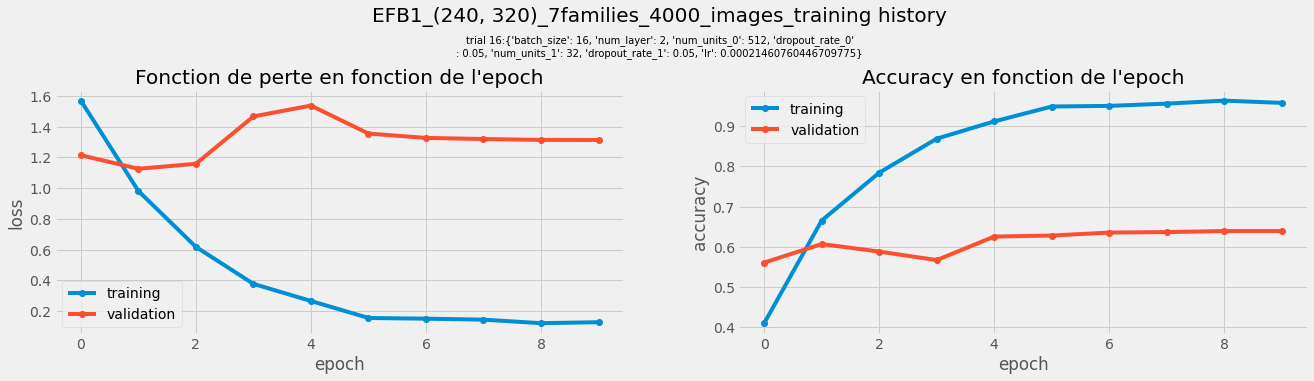

[I 2022-02-03 19:58:53,761] Trial 16 finished with value: 0.6387500166893005 and parameters: {'batch_size': 16, 'num_layer': 2, 'num_units_0': 512, 'dropout_rate_0': 0.05, 'num_units_1': 32, 'dropout_rate_1': 0.05, 'lr': 0.00021460760446709775}. Best is trial 16 with value: 0.6387500166893005.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 17:{'batch_size': 8, 'num_layer': 4, 'num_units_0': 256, 'dropout_rate_0': 0.25, 'num_units_1': 64, 'dropout_rate_1': 0.5, 
'num_units_2': 64, 'dropout_rate_2': 0.4, 'num_units_3': 512, 'dropout_rate_3': 0.35000000000000003, 'lr': 8.866622154429289e-05}
layer.trainable = True : trainable_count = 6898599 / non_trainable_count =  62055
Epoch 1/10
400/400 [==============================] - 98s 206ms/step - loss: 1.9454 - accuracy: 0.1513 - val_loss: 1.9086 - val_accuracy: 0.2475 - lr: 8.8666e-05
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 1.8852 - accuracy: 0.1981

[I 2022-02-03 20:02:55,633] Trial 17 pruned. Trial was pruned at epoch 1.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 18:{'batch_size': 32, 'num_layer': 5, 'num_units_0': 128, 'dropout_rate_0': 0.35000000000000003, 'num_units_1': 32, 'dropout_rate_1': 0.45, 'num_units_2': 2048, 
'dropout_rate_2': 0.15000000000000002, 'num_units_3': 128, 'dropout_rate_3': 0.0, 'num_units_4': 64, 'dropout_rate_4': 0.35000000000000003, 'lr': 0.0008716273268716821}
layer.trainable = True : trainable_count = 7019847 / non_trainable_count =  62055
Epoch 1/10
100/100 [==============================] - 71s 561ms/step - loss: 1.9058 - accuracy: 0.1994 - val_loss: 4.4639 - val_accuracy: 0.1525 - lr: 8.7163e-04
Epoch 2/10
100/100 [==============================] - 54s 537ms/step - loss: 1.7674 - accuracy: 0.3009 - val_loss: 2.0107 - val_accuracy: 0.2100 - lr: 8.7163e-04
Epoch 3/10
100/

[I 2022-02-03 20:15:01,020] Trial 18 pruned. Trial was pruned at epoch 9.



Epoch 00010: ReduceLROnPlateau reducing learning rate to 8.716273005120456e-06.
************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 19:{'batch_size': 8, 'num_layer': 5, 'num_units_0': 512, 'dropout_rate_0': 0.35000000000000003, 'num_units_1': 128, 'dropout_rate_1': 0.25, 'num_units_2'
: 512, 'dropout_rate_2': 0.25, 'num_units_3': 32, 'dropout_rate_3': 0.30000000000000004, 'num_units_4': 32, 'dropout_rate_4': 0.1, 'lr': 0.00023156900535006053}
layer.trainable = True : trainable_count = 7318471 / non_trainable_count =  62055
Epoch 1/10
400/400 [==============================] - 98s 210ms/step - loss: 1.8930 - accuracy: 0.2078 - val_loss: 1.7005 - val_accuracy: 0.3063 - lr: 2.3157e-04
Epoch 2/10
400/400 [==============================] - 81s 203ms/step - loss: 1.7180 - accuracy: 0.2969 - val_los

[I 2022-02-03 20:30:24,290] Trial 19 pruned. Trial was pruned at epoch 9.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 20:{'batch_size': 16, 'num_layer': 2, 'num_units_0': 128, 'dropout_rate_0
': 0.25, 'num_units_1': 32, 'dropout_rate_1': 0.25, 'lr': 0.000186899277454402}
layer.trainable = True : trainable_count = 6681511 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 80s 325ms/step - loss: 1.8012 - accuracy: 0.2869 - val_loss: 1.4269 - val_accuracy: 0.4737 - lr: 1.8690e-04
Epoch 2/10
200/200 [==============================] - 63s 312ms/step - loss: 1.3983 - accuracy: 0.4944 - val_loss: 1.1855 - val_accuracy: 0.5962 - lr: 1.8690e-04
Epoch 3/10
200/200 [==============================] - 63s 313ms/step - loss: 1.0431 - accuracy: 0.6425 - val_loss: 1.1322 - val_accuracy: 0.5925 - lr: 1.8690e-04
Epoch 4/10
200/200 [==========

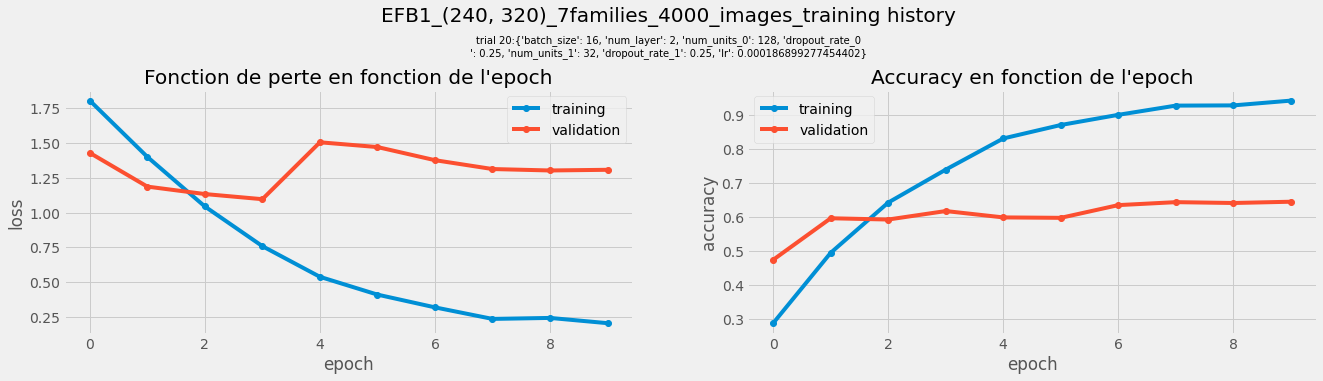

[I 2022-02-03 20:43:29,970] Trial 20 finished with value: 0.6449999809265137 and parameters: {'batch_size': 16, 'num_layer': 2, 'num_units_0': 128, 'dropout_rate_0': 0.25, 'num_units_1': 32, 'dropout_rate_1': 0.25, 'lr': 0.000186899277454402}. Best is trial 20 with value: 0.6449999809265137.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 21:{'batch_size': 32, 'num_layer': 4, 'num_units_0': 32, 'dropout_rate_0': 0.45, 'num_units_1': 64, 'dropout_rate_1'
: 0.5, 'num_units_2': 256, 'dropout_rate_2': 0.05, 'num_units_3': 64, 'dropout_rate_3': 0.0, 'lr': 2.8636003095200804e-05}
layer.trainable = True : trainable_count = 6589831 / non_trainable_count =  62055
Epoch 1/10
100/100 [==============================] - 71s 560ms/step - loss: 1.9516 - accuracy: 0.1531 - val_loss: 1.9427 - val_accuracy: 0.1587 - lr: 2.8636e-05
Epoch 2/10
100/100 [==============================] - 54s 535ms/step - loss: 1.9434 - accuracy: 0.1647 - val_loss: 1.9384 - val_accuracy: 0.1762 - lr: 2.8636e-05
Epoch 3/10
100/100 [==============================] - 54s 538ms/step - loss: 1.9348 - accuracy: 0.1744 - v

[I 2022-02-03 20:48:22,841] Trial 21 pruned. Trial was pruned at epoch 3.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 22:{'batch_size': 16, 'num_layer': 5, 'num_units_0': 1024, 'dropout_rate_0': 0.35000000000000003, 'num_units_1': 2048, 'dropout_rate_1': 0.0, 'num
_units_2': 32, 'dropout_rate_2': 0.2, 'num_units_3': 128, 'dropout_rate_3': 0.45, 'num_units_4': 64, 'dropout_rate_4': 0.45, 'lr': 0.0009147021810152679}
layer.trainable = True : trainable_count = 10002631 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 80s 326ms/step - loss: 1.9473 - accuracy: 0.1419 - val_loss: 1.9449 - val_accuracy: 0.1700 - lr: 9.1470e-04
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 1.9467 - accuracy: 0.1400

[I 2022-02-03 20:51:34,429] Trial 22 pruned. Trial was pruned at epoch 1.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 23:{'batch_size': 16, 'num_layer': 4, 'num_units_0': 128, 'dropout_rate_0': 0.0, 'num_units_1': 1024, 'dropout_rate_1
': 0.2, 'num_units_2': 128, 'dropout_rate_2': 0.1, 'num_units_3': 1024, 'dropout_rate_3': 0.5, 'lr': 0.0002442982548640264}
layer.trainable = True : trainable_count = 7079719 / non_trainable_count =  62055
Epoch 1/10
200/200 [==============================] - 83s 324ms/step - loss: 1.7548 - accuracy: 0.3094 - val_loss: 1.5055 - val_accuracy: 0.4812 - lr: 2.4430e-04
Epoch 2/10
200/200 [==============================] - 63s 314ms/step - loss: 1.2642 - accuracy: 0.5584 - val_loss: 1.2924 - val_accuracy: 0.5550 - lr: 2.4430e-04
Epoch 3/10
200/200 [==============================] - 63s 314ms/step - loss: 0.8598 - accuracy: 0.7134 -

[I 2022-02-03 21:04:37,855] Trial 23 pruned. Trial was pruned at epoch 9.


************************************************************************************************************************
Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
trial 24:{'batch_size': 8, 'num_layer': 2, 'num_units_0': 2048, 'dropout_rate_0'
: 0.1, 'num_units_1': 1024, 'dropout_rate_1': 0.0, 'lr': 1.1669832432751508e-05}
layer.trainable = True : trainable_count = 11242023 / non_trainable_count =  62055
Epoch 1/10
400/400 [==============================] - 98s 209ms/step - loss: 1.8788 - accuracy: 0.2637 - val_loss: 1.7443 - val_accuracy: 0.4125 - lr: 1.1670e-05
Epoch 2/10
400/400 [==============================] - 81s 203ms/step - loss: 1.6250 - accuracy: 0.4406 - val_loss: 1.4522 - val_accuracy: 0.4963 - lr: 1.1670e-05
Epoch 3/10
400/400 [==============================] - 81s 204ms/step - loss: 1.3965 - accuracy: 0.4991 - val_loss: 1.3086 - val_accuracy: 0.5288 - lr: 1.1670e-05
Epoch 4/10
400/400 [=======

[I 2022-02-03 21:19:33,581] Trial 24 pruned. Trial was pruned at epoch 9.


time: 4h 12min 4s (started: 2022-02-03 17:07:28 +00:00)


In [106]:
def objective2(trial):
  print('*'*120)
  # split train/val 
  df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
  # train datagenerator
  train_data_generator = ImageDataGenerator(
                                            # rotation_range=trial.suggest_discrete_uniform('rotation_range', 0.0,90,45),
                                            # width_shift_range=trial.suggest_discrete_uniform('width_shift_range', 0.0, 0.2,0.1),
                                            # height_shift_range=trial.suggest_discrete_uniform('height_shift_range', 0.0, 0.2,0.1),
                                            # shear_range=trial.suggest_discrete_uniform('shear_range=', 0.0, 0.2,0.1),
                                            # zoom_range=trial.suggest_discrete_uniform('zoom_range', 0.0, 0.2,0.1),
                                            # horizontal_flip=trial.suggest_categorical("horizontal_flip", [True,False]),
                                            # vertical_flip=trial.suggest_categorical("vertical_flip", [True,False]),
                                            # fill_mode='nearest',
                                          ) 
  batch_size  = trial.suggest_categorical("batch_size", [8, 16, 32]) # , 
  train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
                                                           x_col = "drive_file_path",y_col="label", 
                                                           target_size=resol,batch_size=batch_size,class_mode='sparse')

  #val datagenerator
  val_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_val_,
                                                         x_col = "drive_file_path",y_col="label", 
                                                           target_size=resol,batch_size=batch_size,class_mode='sparse')
  
  # base model layers 
  model_name  = 'EFB1'
  weights = 'imagenet' # trial.suggest_categorical("weights", [None,'imagenet'])
  base_model =  tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),
                                                     weights=weights,
                                                     include_top=False)
  # base_model =base_model 
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
  layers = [ base_model,  global_average_layer ]
  # define a number of classifier layers 
  num_layer = trial.suggest_int("num_layer", 2, 5) #number of the convolution + drop out layers
  # create dict of layers with variouus unit numer & dropout  
  layer_properties = {}
  for i in range(num_layer):  
    units = trial.suggest_categorical("num_units_" + str(i), [32, 64, 128, 256, 512,1024,2048])
    dropout = trial.suggest_discrete_uniform('dropout_rate_'+ str(i), 0.0, 0.5,0.05)
    layer_properties[i] = [units,dropout]
  # add classifiers layers (succession de Dense + dropout ) 
  for k,v in layer_properties.items():
    units,dropout = v
    layers.append(tf.keras.layers.Dense(units = units, activation = 'relu'))
    layers.append(tf.keras.layers.Dropout(dropout))
  # add predICTION layers 
  layers.append(Dense(units = classes_count, activation = 'softmax'))
  #freeze/unfreeze all layers 
  for layer in base_model.layers:
      layer.trainable = base_model_trainable # trial.suggest_categorical("base_model_trainable", [True,False]) 
  # build model        
  model = tf.keras.Sequential(layers,name = model_name)
  # optimizer 
  optimizer = "adam" #  trial.suggest_categorical("optimizer", ["sgd", "adam"]) 
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
  # compilation 
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
  # Add a callback for pruning cf optuna 
  pruning_callback = optuna.integration.TFKerasPruningCallback(trial, "val_accuracy") # pruning sur le set d'evaluation 
  # csv start path infos 
  pathinfos = str(model.name) + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
  ## Entraînement
  text = 'trial ' + str(trial.number) + ':' + str(trial.params)
  t1, t2 = text[:len(text)//2],text[len(text)//2:]
  print(t1 + '\n' + t2)
  print('layer.trainable = {} : trainable_count = {} / non_trainable_count =  {}'.format(layer.trainable,
                                                                                         count_params(model.trainable_weights),
                                                                                         count_params(model.non_trainable_weights)))
  training_history_model = model.fit(train_generator,
                                   epochs=epochs,
                                   steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,
                                  validation_steps = len(df_val_)//batch_size,
                                   class_weight=class_weights,
                                  callbacks=[
                                             early_stopping,reduce_learning_rate, #KERAS
                                             pruning_callback # optuna 
                                             ])
  
  # Plot hIStory 
  training_history_fig = plot_history(training_history_model,pathinfos)
  # add trial infos
  training_history_fig.text(0.5,0.85,t1 + '\n' + t2 ,ha= 'center',fontsize=10,wrap=True)
  display(training_history_fig)
  # save fig + model summary
  trial_infos =  '_trial' + str(trial.number)
  training_history_fig.savefig(export_dir + pathinfos +  trial_infos  +  '_training_history.jpeg' )
  with open(export_dir + pathinfos +  trial_infos  +  '_modelsummary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

  return training_history_model.history['val_accuracy'][-1]

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize',
                            pruner=optuna.pruners.HyperbandPruner()
                            # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
                            ) 
study.optimize(objective2, n_trials=n_trials,)

In [107]:
trial_df = study.trials_dataframe()
display(trial_df)
trial_df.to_csv(export_dir + 'optuna_trials.csv')

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate_0,params_dropout_rate_1,params_dropout_rate_2,params_dropout_rate_3,params_dropout_rate_4,params_lr,params_num_layer,params_num_units_0,params_num_units_1,params_num_units_2,params_num_units_3,params_num_units_4,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,state
0,0,0.50875,2022-02-03 17:07:28.938698,2022-02-03 17:20:32.817450,0 days 00:13:03.878752,32,0.45,0.00,0.50,0.05,0.00,0.000036,5,512,128,32.0,128.0,2048.0,NaN,NaN,NaN,COMPLETE
1,1,0.62875,2022-02-03 17:20:32.819973,2022-02-03 17:30:45.344502,0 days 00:10:12.524529,16,0.05,0.00,NaN,NaN,NaN,0.000207,2,64,128,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
2,2,0.51500,2022-02-03 17:30:45.346659,2022-02-03 17:44:07.303907,0 days 00:13:21.957248,16,0.40,0.50,NaN,NaN,NaN,0.000023,2,64,32,NaN,NaN,NaN,0.22750,0.33125,0.515,COMPLETE
3,3,0.60625,2022-02-03 17:44:07.311880,2022-02-03 17:53:42.192606,0 days 00:09:34.880726,16,0.35,0.15,0.30,0.45,NaN,0.000102,4,128,1024,64.0,2048.0,NaN,0.53375,0.58500,NaN,COMPLETE
4,4,0.56375,2022-02-03 17:53:42.195113,2022-02-03 18:05:49.587863,0 days 00:12:07.392750,32,0.30,0.05,0.25,0.15,NaN,0.000758,4,64,1024,32.0,2048.0,NaN,0.50125,0.56375,NaN,COMPLETE
5,5,0.61250,2022-02-03 18:05:49.590309,2022-02-03 18:18:49.343494,0 days 00:12:59.753185,16,0.45,0.40,NaN,NaN,NaN,0.000060,2,512,64,NaN,NaN,NaN,0.56750,0.61250,NaN,COMPLETE
6,6,0.39875,2022-02-03 18:18:49.345751,2022-02-03 18:21:23.489040,0 days 00:02:34.143289,32,0.30,0.25,0.00,0.35,0.35,0.000475,5,128,32,2048.0,256.0,32.0,0.39875,NaN,NaN,PRUNED
7,7,0.54750,2022-02-03 18:21:23.490643,2022-02-03 18:35:09.004650,0 days 00:13:45.514007,16,0.00,0.25,0.30,NaN,NaN,0.000020,3,32,64,64.0,NaN,NaN,0.54750,NaN,NaN,COMPLETE
8,8,0.61250,2022-02-03 18:35:09.006938,2022-02-03 18:50:06.649536,0 days 00:14:57.642598,8,0.15,0.10,0.50,NaN,NaN,0.000049,3,256,128,32.0,NaN,NaN,0.61250,NaN,NaN,COMPLETE
9,9,0.58375,2022-02-03 18:50:06.652011,2022-02-03 18:56:51.267807,0 days 00:06:44.615796,8,0.00,0.10,NaN,NaN,NaN,0.000246,2,256,128,NaN,NaN,NaN,0.56625,0.58375,NaN,PRUNED


time: 727 ms (started: 2022-02-03 21:19:33 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



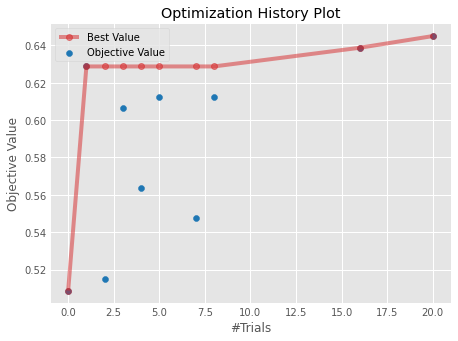

time: 430 ms (started: 2022-02-03 21:19:34 +00:00)


In [108]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig(export_dir + pathinfos +  '_plot_optimization_history.jpeg',bbox_inches='tight'  )

In [109]:
fig = optuna.visualization.plot_intermediate_values(study)
plt.savefig(export_dir + pathinfos +  '_plot_intermediate_values.jpeg' )

<Figure size 460.8x345.6 with 0 Axes>

time: 49.4 ms (started: 2022-02-03 21:19:34 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/visualization/matplotlib/_slice.py:188: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/usr/local/lib/python3.7/dist-packages/optuna/visualization/matplotlib/_slice.py:188: UserWarning:

Attempting to set identical left == right == 2048.0 results in singular transformations; automatically expanding.



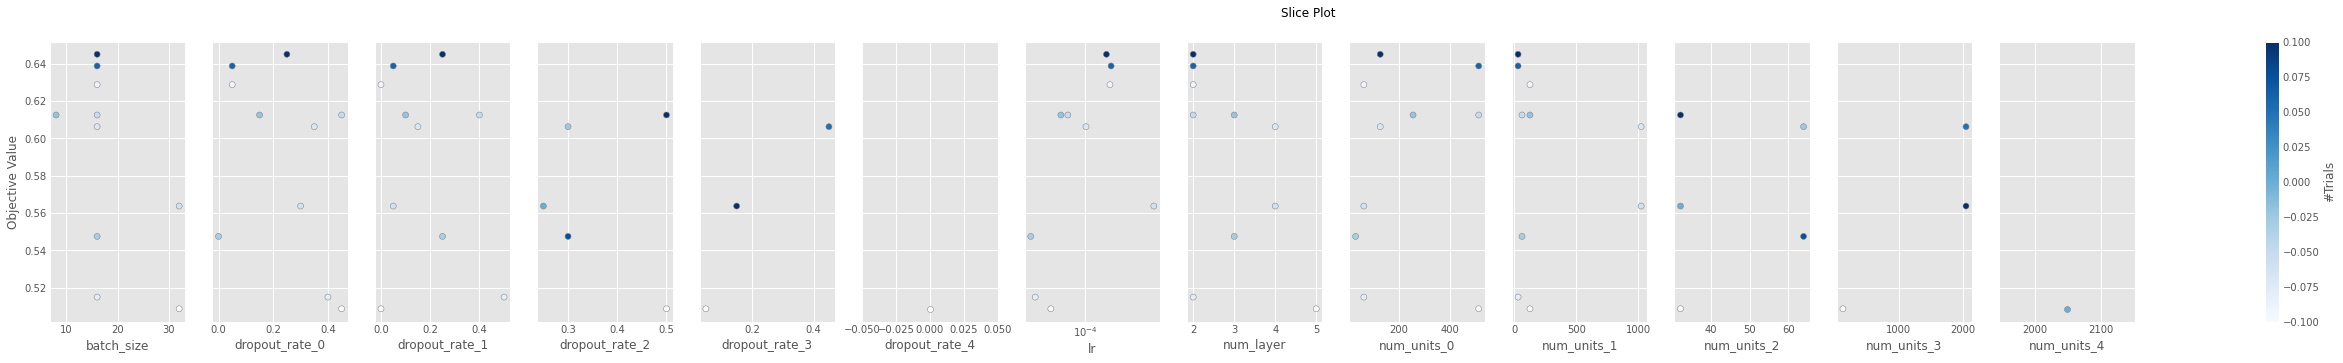

time: 3.77 s (started: 2022-02-03 21:19:34 +00:00)


In [110]:
fig = optuna.visualization.matplotlib.plot_slice(study)
plt.savefig(export_dir + pathinfos +  '_plot_slice.jpeg',bbox_inches='tight' )

In [111]:
# optuna.visualization.plot_parallel_coordinate(study)

time: 1.02 ms (started: 2022-02-03 21:19:38 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



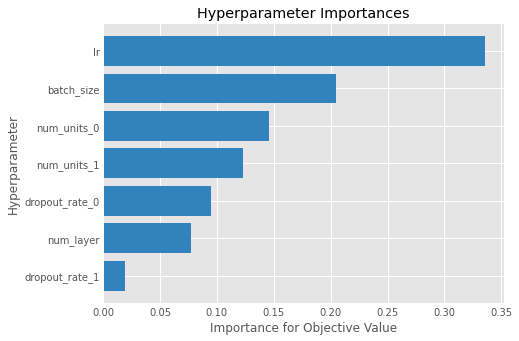

time: 753 ms (started: 2022-02-03 21:19:38 +00:00)


In [112]:
#Visualize parameter importances.
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig(export_dir + pathinfos +  '_plot_param_importances.jpeg' ,bbox_inches='tight' )

In [113]:
print('Best trial is number {}: score {},\nparams {}'.format(study.best_trial.number,study.best_trial.value,study.best_trial.params))

Best trial is number 20: score 0.6449999809265137,
params {'batch_size': 16, 'num_layer': 2, 'num_units_0': 128, 'dropout_rate_0': 0.25, 'num_units_1': 32, 'dropout_rate_1': 0.25, 'lr': 0.000186899277454402}
time: 3.01 ms (started: 2022-02-03 21:19:39 +00:00)


# Best model fit on whole train

## Define best model

In [114]:
study.best_trial.params

{'batch_size': 16,
 'dropout_rate_0': 0.25,
 'dropout_rate_1': 0.25,
 'lr': 0.000186899277454402,
 'num_layer': 2,
 'num_units_0': 128,
 'num_units_1': 32}

time: 10.8 ms (started: 2022-02-03 21:19:39 +00:00)


In [115]:
# DEFINE BEST MODEL Param
#generator 
# rotation_range=study.best_trial.params['rotation_range']
# width_shift_range=study.best_trial.params['width_shift_range']
# height_shift_range=study.best_trial.params['height_shift_range']
# shear_range=study.best_trial.params['shear_range=']
# zoom_range=study.best_trial.params['zoom_range']
# horizontal_flip=study.best_trial.params["horizontal_flip"]
# vertical_flip=study.best_trial.params["vertical_flip"]

# model 
batch_size  = study.best_trial.params['batch_size']
lr = study.best_trial.params['lr']
num_layer = study.best_trial.params['num_layer']
# last_layer_trainable= study.best_trial.params['last_layer_trainable']
# base_model_trainable= study.best_trial.params['base_model_trainable']
layer_units, layer_dropouts = {}, {}
for k,v in study.best_trial.params.items():
  if 'num_units' in k:
    layer_units[int(k[-1:])] = v
  if 'dropout_rate' in k:
    layer_dropouts[int(k[-1:])] = v

time: 19.7 ms (started: 2022-02-03 21:19:39 +00:00)


In [116]:
# train 
train_data_generator = ImageDataGenerator(
                                          # rotation_range=rotation_range,
                                          # width_shift_range=width_shift_range,
                                          # height_shift_range=height_shift_range,
                                          # shear_range=shear_range,
                                          # zoom_range=zoom_range,
                                          # horizontal_flip=horizontal_flip,
                                          # vertical_flip=vertical_flip
                                          # fill_mode='nearest',
                                        ) 
train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train, 
                                                          x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')

#test 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')

# construct model 
# base + average 
layers = [base_model,tf.keras.layers.GlobalAveragePooling2D()] 
# dense + dropout 
for i in range(num_layer):
      layers.append(tf.keras.layers.Dense(units =layer_units[i], activation = 'relu'))
      layers.append(tf.keras.layers.Dropout(layer_dropouts[i]))
# prediction 
layers.append(Dense(units = classes_count, activation = 'softmax'))
#freeze/unfreeze all layers 
for layer in base_model.layers:
    layer.trainable = base_model_trainable
#create model 
model = tf.keras.Sequential(layers,name = model_name)
model.summary()

Found 4000 validated image filenames belonging to 7 classes.
Found 1000 validated image filenames belonging to 7 classes.
Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d_56  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_245 (Dense)           (None, 128)               163968    
                                                                 
 dropout_191 (Dropout)       (None, 128)               0         
                                                                 
 dense_246 (Dense)           (None, 32)                4128      
                                                                 
 dropo

## Training

In [117]:
# compilation 
optimizer =  'Adam'
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
# Entraînement
tic = time.time() # timer start
training_history_model = model.fit(train_generator,
                                   epochs=epochs,
                                   steps_per_epoch = len(df_train)//batch_size,
                                  validation_data = test_generator,
                                  validation_steps = len(df_test)//batch_size,
                                   class_weight=class_weights,
                                  callbacks=[
                                             early_stopping,reduce_learning_rate
                                             ])
# timer end 
tac = time.time()
time_to_fit = tic - tac

Epoch 1/10
250/250 [==============================] - 93s 312ms/step - loss: 1.7138 - accuracy: 0.3273 - val_loss: 1.3221 - val_accuracy: 0.5353 - lr: 1.8690e-04
Epoch 2/10
250/250 [==============================] - 76s 302ms/step - loss: 1.2560 - accuracy: 0.5650 - val_loss: 1.2295 - val_accuracy: 0.5716 - lr: 1.8690e-04
Epoch 3/10
250/250 [==============================] - 76s 303ms/step - loss: 0.9438 - accuracy: 0.6747 - val_loss: 1.1386 - val_accuracy: 0.6079 - lr: 1.8690e-04
Epoch 4/10
250/250 [==============================] - 76s 303ms/step - loss: 0.6899 - accuracy: 0.7705 - val_loss: 1.1383 - val_accuracy: 0.6331 - lr: 1.8690e-04
Epoch 5/10
250/250 [==============================] - 76s 302ms/step - loss: 0.4915 - accuracy: 0.8455 - val_loss: 1.1860 - val_accuracy: 0.6129 - lr: 1.8690e-04
Epoch 6/10
250/250 [==============================] - 76s 303ms/step - loss: 0.3790 - accuracy: 0.8798 - val_loss: 1.4519 - val_accuracy: 0.6119 - lr: 1.8690e-04
Epoch 7/10
250/250 [========

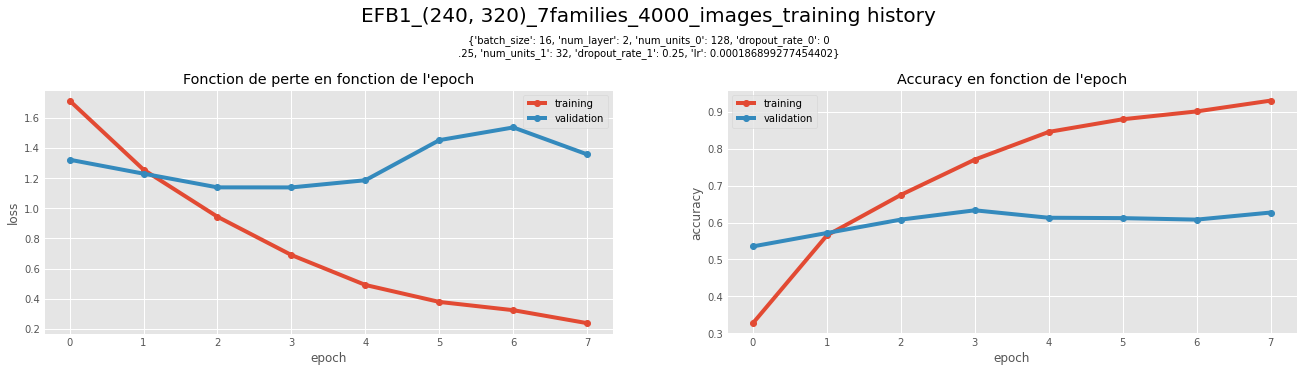

time: 1.85 s (started: 2022-02-03 21:46:25 +00:00)


In [128]:
# save  & export history 
hist_df = pd.DataFrame(training_history_model.history)
hist_df.to_csv(export_dir + pathinfos + '_best_model_history.csv')
training_history_fig = plot_history(training_history_model,pathinfos)
# add text with best param 
text = str(study.best_trial.params)
t1, t2 = text[:len(text)//2],text[len(text)//2:]
training_history_fig.text(0.5,0.85,t1 + '\n' + t2 ,ha= 'center',fontsize=10,wrap=True)
display(training_history_fig)
training_history_fig.savefig(export_dir + pathinfos +  '_BEST model training_history.jpeg' )

# Assess on test

In [129]:
  #test datagenerator
  test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                         x_col = "drive_file_path",y_col="label", 
                                                           target_size=resol,batch_size=batch_size,class_mode='sparse')

Found 1000 validated image filenames belonging to 7 classes.
time: 45.8 ms (started: 2022-02-03 21:46:40 +00:00)


In [130]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 53.1 ms (started: 2022-02-03 21:46:52 +00:00)


In [131]:
# define X test 
X_test_path = df_test['drive_file_path']
X_test = []
for filepath in tqdm(X_test_path):
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    # Redimensionnement
    im = tf.image.resize(im, size=resol)
    X_test.append([im])
    
X_test = tf.concat(X_test, axis=0)
# predict y_test
y_prob = model.predict(X_test, batch_size=16)
test_pred_class = tf.argmax(y_prob, axis = 1).numpy()
y_test_class= df_test['label'].astype(int) 
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + pathinfos + '_classification report.csv'
report.to_csv(report_path)

100%|██████████| 1000/1000 [00:06<00:00, 156.28it/s]


              precision    recall  f1-score   support

           0       0.66      0.64      0.65       171
           1       0.78      0.74      0.76       169
           2       0.59      0.69      0.64       126
           3       0.52      0.56      0.54       139
           4       0.80      0.62      0.69       133
           5       0.63      0.63      0.63       147
           6       0.45      0.50      0.48       115

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.64      0.63      0.63      1000

time: 12.7 s (started: 2022-02-03 21:47:03 +00:00)


##  Conf matrix

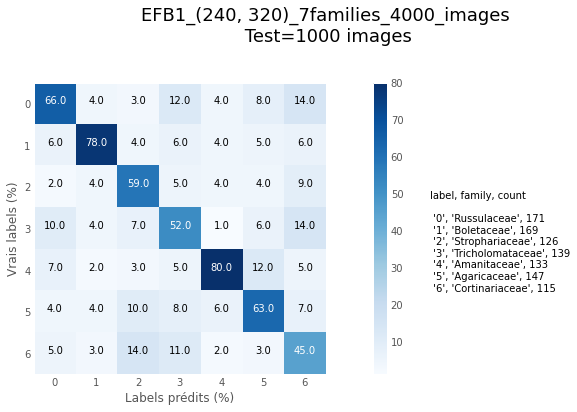

time: 2.93 s (started: 2022-02-03 21:47:15 +00:00)


In [132]:
# conf matrix  
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')

In [133]:
training_epochs = len(training_history_model.history['loss'])
train_acc = round(training_history_model.history['accuracy'][-1],2)
# val_acc = round(training_history_model.history['val_accuracy'][-1],2)
test_acc = round(training_history_model.history['val_accuracy'][-1],2)
fit_time = -round(time_to_fit/60,1)
results_folder = os.path.basename(os.path.dirname(export_dir))
print('train/val/test acc={}/{} in {} epochs in {} minutes with model {} in folder {}'.format(train_acc,test_acc,training_epochs,fit_time,model.name,results_folder))

train/val/test acc=0.93/0.63 in 8 epochs in 11.0 minutes with model EFB1 in folder 220203_17H07
time: 38.7 ms (started: 2022-02-03 21:47:21 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2022-02-03 21:47:29,087] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2022-02-03 21:47:59,066] Param dropout_rate_4 unique value length is less than 2.
[W 2022-02-03 21:48:27,908] Param num_units_4 unique value length is less than 2.
[W 2022-02-03 21:48:44,653] Param dropout_rate_4 unique value length is less than 2.
[W 2022-02-03 21:49:11,888] Param num_units_4 unique value length is less than 2.
[W 2022-02-03 21:49:28,426] Param dropout_rate_4 unique value length is less than 2.
[W 2022-02-03 21:49:53,594] Param num_units_4 unique value length is less than 2.
[W 2022-02-03 21:50:10,261] Param dropout_rate_4 unique value length is less than 2.
[W 2022-02-03 21:50:35,680] Param num_units_4 unique value length is less t

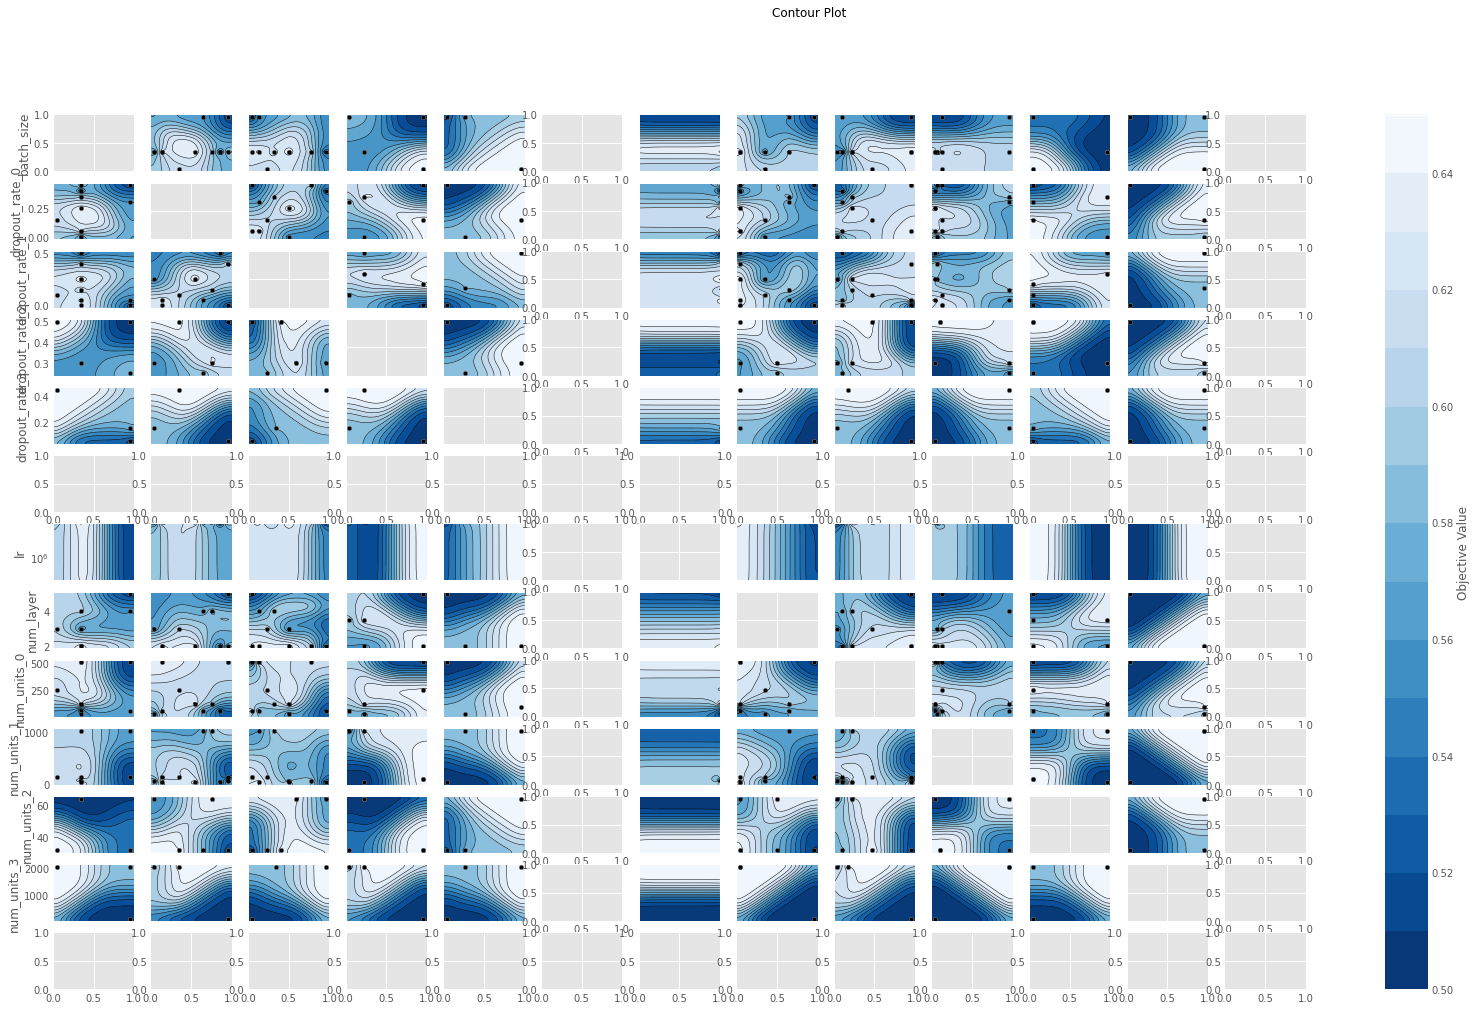

time: 9min 15s (started: 2022-02-03 21:47:29 +00:00)


In [134]:
# à la fin car very long 
from matplotlib import rcParams
rcParams['figure.figsize'] = 25,15
optuna.visualization.matplotlib.plot_contour(study) #DEBUG,['num_units_0','lr']
plt.savefig(export_dir + pathinfos +  '_plot_contour.jpeg' ,bbox_inches='tight' )
rcParams['figure.figsize'] = 6.4, 4.8 #reset to default 

# Experiments (with 5000 images)
* jusqu'ici max val acc avec 4k training = 0.62 
* Split en 3 datasetq Train 3200 , val 800, test 1000 + defreeze du base model dans optnuna:
  * NOK si on initialise les coefs de façon random
  * acc > 0.644 sur valid set avec defreeze + initialisation imagnet, mais pas pu évaluer jusqu'au test set car plantage (dossier DEEP LEARNING/220202_14H18)
* Relance avec unfreeze always = True + change pruner optuna (medianpruner -> HyperbandPruner)
  * train/val/test acc=0.95/0.62 in 8 epochs in 12.0 minutes with model EFB1 in folder 220203_12H29
* Limitation interval recherche optuna lr (1e-5, 1e-3) vs (1e-5, 1e-2) & batchsize (8,32) vs (8,64) since most important param
  * train/val/test acc=0.93/0.63 in 8 epochs in 11.0 minutes with model EFB1 in folder 220203_17H07








# TO DO
* relance optuna avec couche de dropout post globalaverage 
* Loop top 3 optuna trials on all images
* optuna + xgboost sur EFB1 en s'inspirant de module style transfer
* try exponnetial lr ? 
* Try to add FRUIT360 ?
* stacking  ML ? 
* random selct plot tf + train : 1 image per class
 * https://support.datascientest.com/t/8-retrouver-image-dans-le-tf-dataset/4033/4

In [127]:
# !kill -9 -1

time: 1.09 ms (started: 2022-02-03 21:45:49 +00:00)
